In [17]:
import ROOT
from ROOT import *
import numpy as np
import ctypes

from constants import *

In [18]:
%%cpp
#include "constants.h"

In [19]:
ROOT.gRandom.SetSeed(0)
ROOT.gStyle.SetOptStat(0)
#ROOT.gStyle.SetMarkerStyle(kPlus)
rng = ROOT.TRandom3()

In [20]:
# read in neutron diffusion distribution
n_diffusion = ROOT.TH1F("n_diffusion", "distribution of path length of neutron", 41, -25, 2025) 
        # bin center at 0:50:2000
    
pdf_file = open('../data/LiqScin_distributions/neutron_diffusion_length.csv')
pdf = np.loadtxt(pdf_file, delimiter=",")
for line in pdf:
    n_diffusion.Fill(line[0], line[1])
    
pdf_file.close()

Warning in <TROOT::Append>: Replacing existing TH1: n_diffusion (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


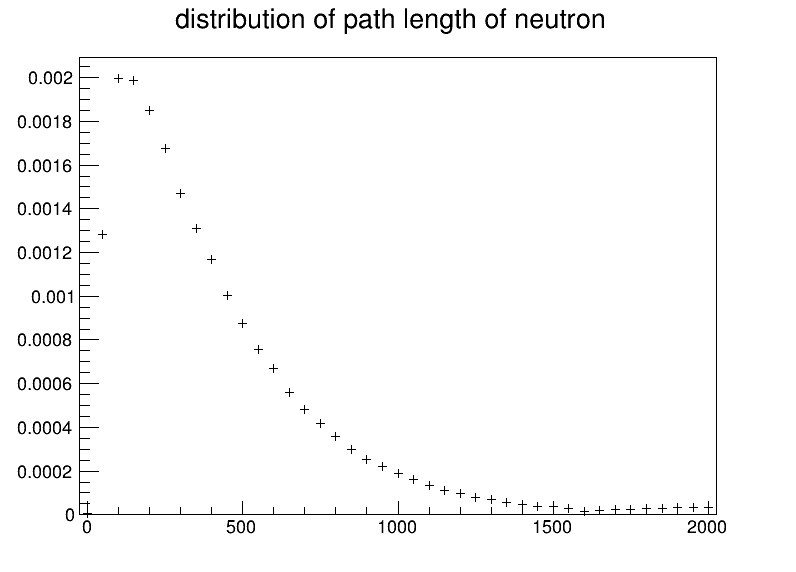

In [21]:
# ... plot it
c1 = ROOT.TCanvas("c1", "c1", 800, 600)
n_diffusion.SetMarkerStyle(kPlus)
n_diffusion.Draw("p hist")
c1.Draw()

In [6]:
n_diffusion.Integral()

0.019931995153456228

In [22]:
def get_n_diffusion():
    return n_diffusion.GetRandom();

### Thermalization distribution
assuming thermalization distributions are exponential

Warning in <TROOT::Append>: Replacing existing TH1: n_thermalize (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


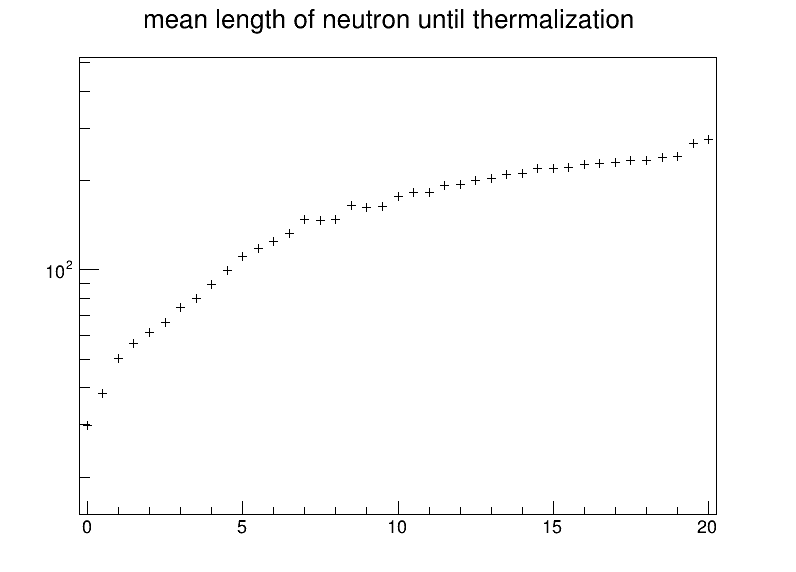

In [23]:
# read distribution, plot

n_thermalize = ROOT.TH1F("n_thermalize", "mean length of neutron until thermalization", 41, -0.25, 20.25) 
n_thermalize.Sumw2()

pdf_file = open('../data/LiqScin_distributions/neutron_thermalization_length.csv')
pdf = np.loadtxt(pdf_file, delimiter=",")
for line in pdf:
    n_thermalize.Fill(line[0], line[1])
pdf_file.close();

n_thermalize.SetMarkerStyle(ROOT.kPlus)

c2 = ROOT.TCanvas("c2", "c2", 800, 600)
c2.SetLogy()

n_thermalize.Draw("hist P")
c2.Draw()

In [24]:
def get_T(E, E0):
    # helper function. Get kinetic energy of particle given total energy and rest mass
    return E - E0


def get_n_thermalize(En):
    '''
    Get the thermalization Path length
    En: Neutron total energy
    '''
    Tn = get_T(En, e0_n)
    #print(Tn)
    mean = n_thermalize.GetBinContent(n_thermalize.FindBin(Tn))
    return mean#rng.Exp(mean)

### Loop through simulated events

In [25]:
def random_sphere(radius=1):
    x = ctypes.c_double(0)
    y = ctypes.c_double(0)
    z = ctypes.c_double(0)
    rng.Sphere(x, y, z, radius)
    return np.array([x.value, y.value, z.value])

def random_cone(cosZ, norm=1):
    # return a vector of length "norm" and of a z direction defined by cosZ
    x = ctypes.c_double(0)
    y = ctypes.c_double(0)
    radius = norm*(1-cosZ**2)
    rng.Circle(x, y, radius)
    return np.array([x.value, y.value, norm*cosZ])

def calculate_n_path(event, use_diffusion=True, gamma_smear=200, detector_smear=200):
    
    # return the path length along the -z direction (in direction of nuebar)
    thermalize_path_length = get_n_thermalize(event.n_energy)
    thermalize_path = random_cone(norm=thermalize_path_length, cosZ=-event.nz)
    
    # diffusion path
    diffusion_path = np.array([0, 0, 0])
    if use_diffusion:
        diffusion_path = random_sphere(radius=get_n_diffusion())
        
        
    # gamma smearing
    gamma_path = random_sphere(radius=rng.Gaus(0, gamma_smear))
    
    #detector smearing
    detector_smear = random_sphere(radius=rng.Gaus(0, detector_smear))
    
    return thermalize_path + diffusion_path + gamma_path + detector_smear

def calculate_n_path_z(e, use_diffusion=True, gamma_smear=200, detector_smear=200):
    return calculate_n_path(e, use_diffusion, gamma_smear, detector_smear)[2]

Info in <TCanvas::Print>: png file ../output/plots/ToyMC/neutron_path.png has been created


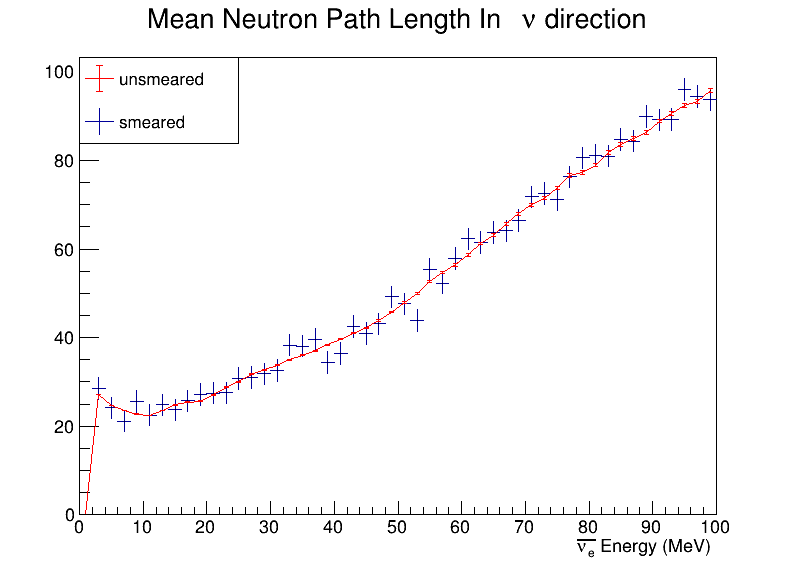

In [26]:
treeFile = TFile("../output/ROOT/kin_results_generated.root")
kin_tree = treeFile.kin_tree
counter = 0

n_path_z_mean_smeared = TProfile("n_path_z_mean_smeared", 
                                 "Mean Neutron Path Length In #nu direction", 50, 0, 100, -7500, 7500)
n_path_z_mean_unsmeared = TProfile("n_path_z_mean_unsmeared", 
                                 "Mean Neutron Path Length In #nu direction", 50, 0, 100, -7500, 7500)

for e in kin_tree:
    n_path_z = calculate_n_path_z(e, use_diffusion=True, gamma_smear=200, detector_smear=200)
    n_path_z_nosmear = calculate_n_path_z(e, use_diffusion=False, gamma_smear=0, detector_smear=0)
    n_path_z_mean_smeared.Fill(e.nuebar_energy, n_path_z, 1)
    n_path_z_mean_unsmeared.Fill(e.nuebar_energy, n_path_z_nosmear, 1)

    
c3 = ROOT.TCanvas("c3", "c3", 800, 600)
n_path_z_mean_smeared.Draw("")

n_path_z_mean_unsmeared.SetLineColor(kRed)
n_path_z_mean_unsmeared.Draw("E1 X0 SAME")
n_path_z_mean_unsmeared.Draw("HIST L SAME")

n_path_z_mean_smeared.GetXaxis().SetTitle("#bar{#nu_{e}} Energy (MeV)")

leg = TLegend(0.1,0.75,0.3,0.9)

leg.AddEntry(n_path_z_mean_unsmeared,"unsmeared","LE")
leg.AddEntry(n_path_z_mean_smeared,"smeared","LE")
leg.Draw()


c3.Draw()
c3.SaveAs("../output/plots/ToyMC/neutron_path.png")

#treeFile.Close()

## Positron

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c4


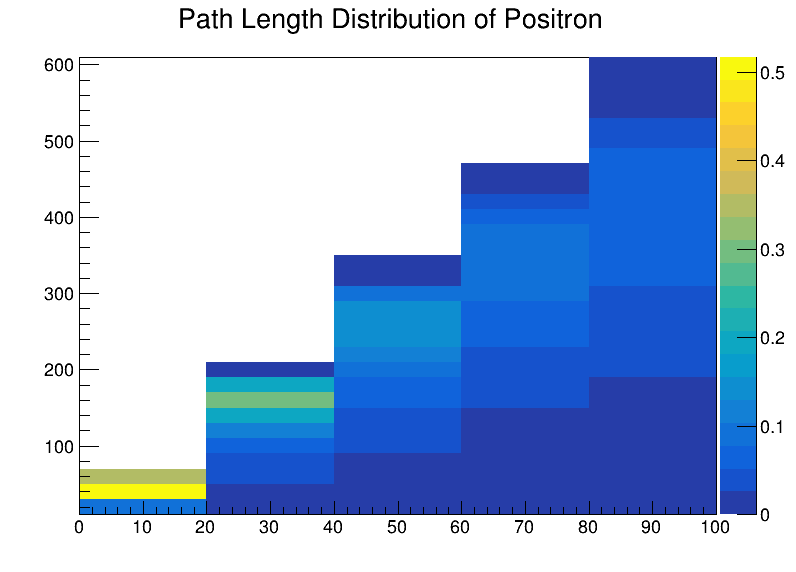

In [27]:
ebar_pathlength_pdf = TH2F("ebar_pathlength_pdf", "Path Length Distribution of Positron", 5, 0, 100, 30, 10, 610) 

energies = [10, 30, 50, 70, 90]
for energy in energies:
    file_path = "../data/LiqScin_distributions/ebar_path_length_kamLAND/{}MeV.csv".format(energy)
    pdf_file = open(file_path)
    pdf = np.loadtxt(pdf_file, delimiter=",")
    for line in pdf:
        #print(line)
        ebar_pathlength_pdf.Fill(energy, line[0], line[1])
    pdf_file.close()

c4 = TCanvas("c4", "c4", 800, 600)
ebar_pathlength_pdf.Draw("colz")
c4.Draw()

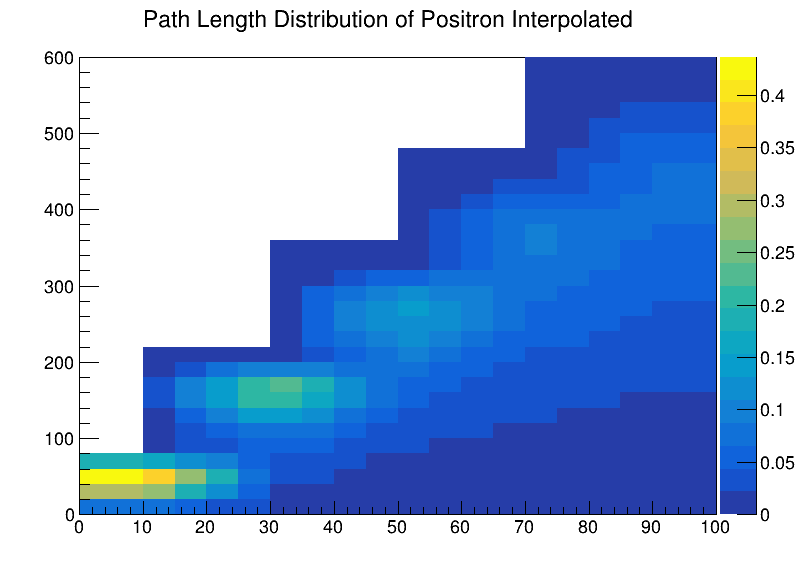

In [28]:
# try to interpolate the distribution...

ebar_pathlength_pdf_interpol = TH2F("ebar_pathlength_pdf_interpol", 
                                   "Path Length Distribution of Positron Interpolated", 20, 0, 100, 30, 0, 600)

for i in range(1,ebar_pathlength_pdf_interpol.GetNbinsX() + 1):
    for j in range(1,ebar_pathlength_pdf_interpol.GetNbinsY() + 1):
        x = ebar_pathlength_pdf_interpol.GetXaxis().GetBinCenter(i)
        y = ebar_pathlength_pdf_interpol.GetYaxis().GetBinCenter(j)
        interpol = ebar_pathlength_pdf.Interpolate(x, y)
        ebar_pathlength_pdf_interpol.SetBinContent(i, j, interpol)
        
ebar_pathlength_pdf_interpol.Draw("colz")
c4.Draw()

In [33]:
def get_ebar_path(E, hist):
    nbin = hist.GetXaxis().FindBin(E)
    py = hist.ProjectionY("projection_y", nbin, nbin)
    ret = py.GetRandom()
    py.Delete()
    return ret


def calculate_ebar_path(event, detector_smear=200, hist=ebar_pathlength_pdf):
    ebar_path_length = get_ebar_path(event.ebar_energy - e0_e, hist)   
    ebar_path = random_cone(norm=ebar_path_length, cosZ=-event.ez)
    
    # path adjustment for uneven energy distribution along path
    ebar_path = ebar_path * 0.72
          
    #detector smearing
    detector_smear = random_sphere(radius=rng.Gaus(0, detector_smear))
    
    return ebar_path + detector_smear


def calculate_ebar_path_z(e, detector_smear=200):
    return calculate_ebar_path(e, detector_smear=200)[2]

Warning in <TFile::Append>: Replacing existing TH1: ebar_path_z_mean_smeared (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ebar_path_z_mean_unsmeared (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5
Info in <TCanvas::Print>: png file ../output/plots/ToyMC/ebar_path.png has been created


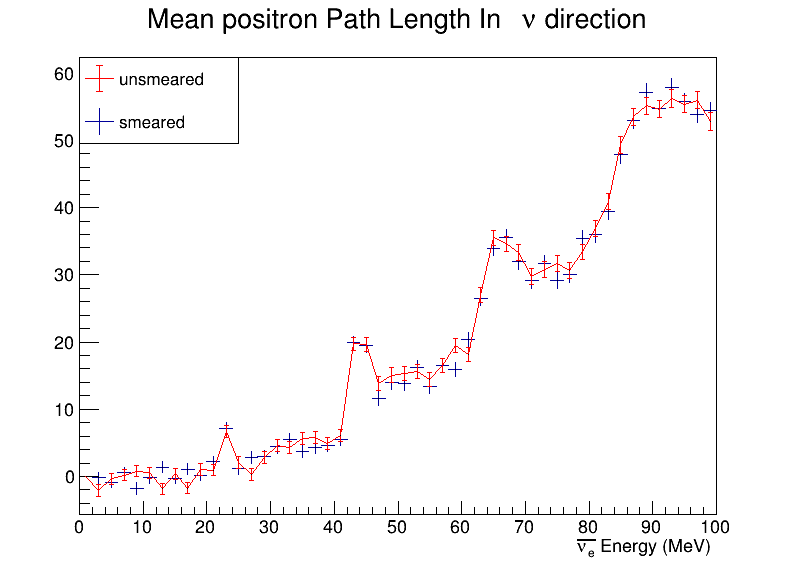

In [34]:
#treeFile.Close()


#treeFile = TFile("../output/ROOT/kin_results.root")
counter=0

ebar_path_z_mean_smeared = TProfile("ebar_path_z_mean_smeared", 
                                 "Mean positron Path Length In #nu direction", 50, 0, 100, -2000, 2000)
ebar_path_z_mean_unsmeared = TProfile("ebar_path_z_mean_unsmeared", 
                                 "Mean positron Path Length In #nu direction", 50, 0, 100, -2000, 2000)

for e in kin_tree:
    #print(counter)
    e_path_z = calculate_ebar_path_z(e, detector_smear=200)
    e_path_z_nosmear = calculate_ebar_path_z(e, detector_smear=0)
    ebar_path_z_mean_smeared.Fill(e.nuebar_energy, e_path_z, 1)
    ebar_path_z_mean_unsmeared.Fill(e.nuebar_energy, e_path_z_nosmear, 1)
    
c5 = ROOT.TCanvas("c5", "c5", 800, 600)
ebar_path_z_mean_smeared.Draw("")

ebar_path_z_mean_unsmeared.SetLineColor(kRed)
ebar_path_z_mean_unsmeared.Draw("E1 X0 SAME")
ebar_path_z_mean_unsmeared.Draw("HIST L SAME")

ebar_path_z_mean_smeared.GetXaxis().SetTitle("#bar{#nu_{e}} Energy (MeV)")

leg = TLegend(0.1,0.75,0.3,0.9)

leg.AddEntry(ebar_path_z_mean_unsmeared,"unsmeared","LE")
leg.AddEntry(ebar_path_z_mean_smeared,"smeared","LE")
leg.Draw()


c5.Draw()
c5.SaveAs("../output/plots/ToyMC/ebar_path.png")

    


There seem to be some weird features...

Right before pathlength distribution sampling points.;

Seem to correspond to discrepencies to the linearity of ebar_cos:nuebar_energy
more data? Linear fit?

Warning in <TFile::Append>: Replacing existing TH1: kin_tree_prof (Potential memory leak).
Info in <TCanvas::Print>: png file ../output/plots/ToyMC/ebar_angle and pathlength trend.png has been created


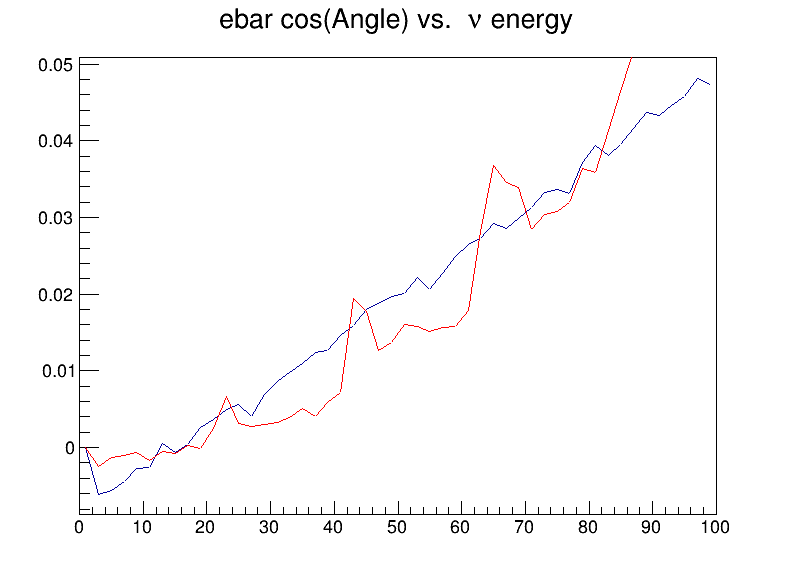

In [16]:
kin_tree_prof = TProfile("kin_tree_prof", "ebar cos(Angle) vs. #nu energy", 50, 0, 100, -1, 1)

kin_tree.Draw("-ez:nuebar_energy>>kin_tree_prof", "", "goff")

kin_tree_prof.DrawNormalized("L HIST")
ebar_path_z_mean_unsmeared.DrawNormalized("SAME L HIST")


c5.Draw()
c5.SaveAs("../output/plots/ToyMC/ebar_angle and pathlength trend.png")

In [16]:
get_ebar_path(10)

66.0895399700809

In [17]:
treeFile = TFile("../output/ROOT/kin_results.root")
kin_tree = treeFile.kin_tree
counter = 0

Couple of things I should still ask about
- Linear fit for the cos(ebar_angle) vs. nuebar energy?
- Distirbutions for neutron thermalization, gamma EXP
- More data?
- Finer sampling for ebar pathlength distribution?
- Applying to snowglobes